In [4]:
from utils import *
import time
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from stock_reader import reader
import sklearn.preprocessing
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
import warnings
import seaborn as sns
sns.set()

In [5]:
warnings.filterwarnings("ignore")

Enter Code or Symbol : 005930
Enter start date(YYYY-MM--DD) : 20080101
Enter end date(YYYY-MM--DD) : 20200422

     Symbol  Name          Sector
947  005930  삼성전자  통신 및 방송 장비 제조업

             open   high    low  close    volume    change
Date                                                      
2008-01-02  11180  11200  10840  10880    360944 -0.021583
2008-01-03  10760  11060  10640  10920    386930  0.003676
2008-01-04  10920  10960  10760  10780    359947 -0.012821
2008-01-07  10360  10480  10340  10380    795744 -0.037106
2008-01-08  10380  10480  10320  10320    495674 -0.005780
...           ...    ...    ...    ...       ...       ...
2020-04-16  49350  49350  48550  49000  23349760  0.000000
2020-04-17  50800  52000  50300  51400  32041675  0.048980
2020-04-20  51400  51400  50000  50100  21866354 -0.025292
2020-04-21  49400  49700  48700  49250  27407543 -0.016966
2020-04-22  48700  50000  48350  49850  18613864  0.012183

[3041 rows x 6 columns]


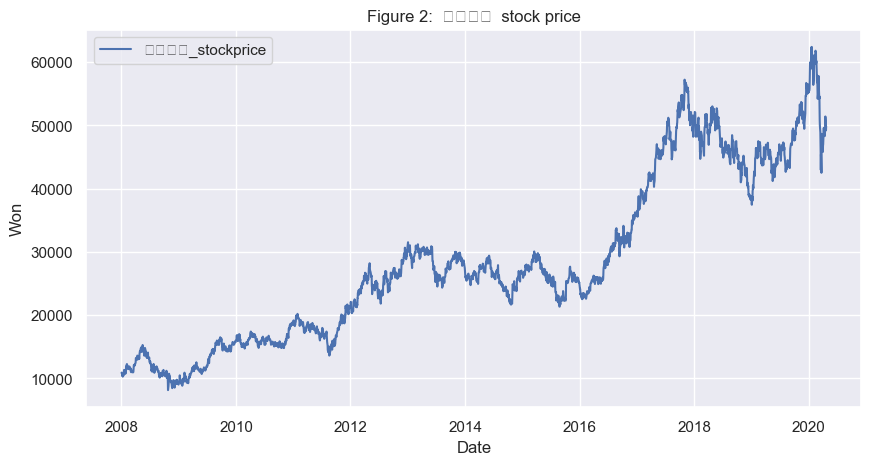


There are 3041 number of days in the dataset.



3041

In [22]:
## load data ## 삼성전자 005930
df = reader()
len(df)

In [7]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2008-01-02,0.0,10880,NaN,NaN
2008-01-03,0.0,10920,NaN,NaN
2008-01-04,0.0,10780,NaN,NaN
2008-01-07,0.0,10380,NaN,NaN
2008-01-08,0.0,10320,NaN,NaN
...,...,...,...,...
2020-04-16,0.0,49000,62400.0,41200.0
2020-04-17,0.0,51400,62400.0,41200.0
2020-04-20,0.0,50100,62400.0,41200.0


In [5]:
count

211

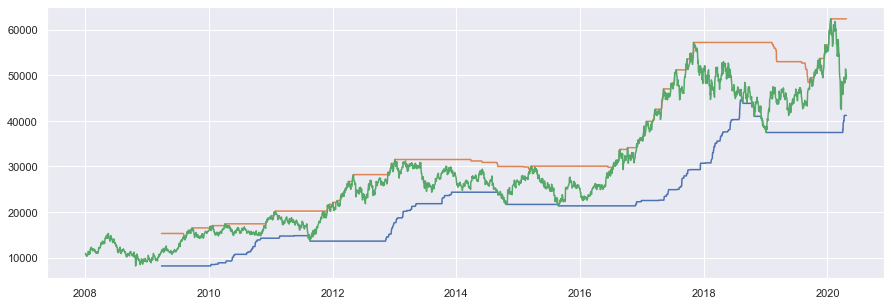

In [8]:
plt.figure(figsize = (15,5))
plt.plot(signals['RollingMin'])
plt.plot(signals['RollingMax'])
plt.plot(signals['trend'])

In [25]:
print(df.close.shape[0])
int(0.025 * len(df))

3041


76

In [18]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000000,
    max_buy = 200,
    max_sell = 100,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory): # i 는 날짜 개수 
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy # shares 가 max_buy 보다 크면 살수 있는 전량을 산다.
            else:
                buy_units = shares # shares 가 max buy 보다 작으면 남은 여력까지 산다.
                
            initial_money -= buy_units * real_movement[i] # 초기금에서 매수금을 뺀다.
            current_inventory += buy_units # 현재 보유량에 매수량을 더함.
            print(
                'day %d: buy %d units at price %f, total balance %f, current inventory %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money, current_inventory)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))): #df.close.shape[0], len(df) 는 날짜 개수 (df 의 전체행의 개수)
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f, currnet inventory %f'
                    % (i, sell_units, total_sell, invest, initial_money, current_inventory)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, current_inventory

In [20]:
states_buy, states_sell, total_gains, invest,current_inventory = buy_stock(df.close, signals['signal'])

day 407: cannot sell anything, inventory 0
day 408: cannot sell anything, inventory 0
day 409: cannot sell anything, inventory 0
day 410: cannot sell anything, inventory 0
day 416: cannot sell anything, inventory 0
day 428: cannot sell anything, inventory 0
day 431: cannot sell anything, inventory 0
day 503: cannot sell anything, inventory 0
day 510: cannot sell anything, inventory 0
day 511: cannot sell anything, inventory 0
day 514: cannot sell anything, inventory 0
day 563: cannot sell anything, inventory 0
day 564: cannot sell anything, inventory 0
day 732: cannot sell anything, inventory 0
day 734: cannot sell anything, inventory 0
day 736: cannot sell anything, inventory 0
day 737: cannot sell anything, inventory 0
day 738: cannot sell anything, inventory 0
day 743: cannot sell anything, inventory 0
day 744: cannot sell anything, inventory 0
day 745: cannot sell anything, inventory 0
day 750: cannot sell anything, inventory 0
day 751: cannot sell anything, inventory 0
day 752: ca

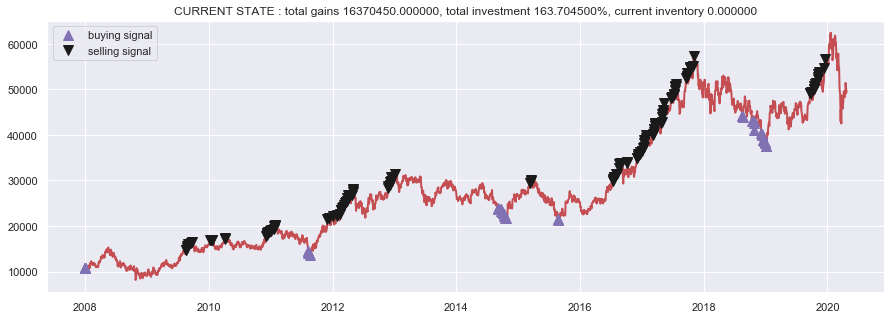

currnet profit(in value) :  16370450


In [21]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('CURRENT STATE : total gains %f, total investment %f%%, current inventory %f'%(total_gains, invest, current_inventory))
plt.legend()
plt.show()

profit = (close[-1]*current_inventory)+total_gains
print("currnet profit(in value) : ", profit)